In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import minerl
from tqdm import tqdm
import random

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

from networks import ConvNeXtBlock, SimpleLayerNorm
from spectralpool import SpectralPool2d
import collections
from autoencoder import VAELatent

import shapes_dataset
# from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import AdvancedAutoencoder
import autoencoder
from ZerO import init_ZerO
from networks import SkippableLayerNorm
from lion_pytorch import Lion

In [9]:
# the basic algorithm:
# https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#
# Q(state, action) -> return (total reward)
# So, implement Q() as a neural net.
# This works because nns are universal function approximators.
# Train it to predict the returns for each action,
# then pick the action with the highest expected return.
# This can be done recursively by doing:
# Q(s, a) = r(s, a) + max(Q(s_n, a_n))
# we can max Q() because we actually implement Q(state) -> List[return]
# So, what we need to do is to make that nn from the observation space to the action space with the returns


In [10]:
# alright, let's make a simple gym

In [11]:
import gym
from gym import spaces

In [12]:
action_to_vector = {
    0: np.array([0, -1]),  # Up
    1: np.array([1, 0]),   # Right
    2: np.array([0, 1]),   # Down
    3: np.array([-1, 0])   # Left
}

In [13]:
import gym
import numpy as np

class DotEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        self.width = 64
        self.height = 64
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(self.height, self.width, 3), dtype=np.uint8)
        self.action_space = gym.spaces.Discrete(4)
        self.dot_position = np.array([0, 0], dtype='int32')
        self.dot_color = np.array([255, 255, 255])
        self.goal_position = np.array([self.width/2, self.height/2], dtype='int32')
        self.viewer = None
        self.reward_range = (-float('inf'), float('inf'))
        self.max_episode_steps = 200
        self.current_step = 0

    def step(self, action):
        # Move the dot according to the action
        if action == 0:  # Up
            self.dot_position[1] = max(self.dot_position[1] - 1, 0)
        elif action == 1:  # Right
            self.dot_position[0] = min(self.dot_position[0] + 1, self.width - 2)
        elif action == 2:  # Down
            self.dot_position[1] = min(self.dot_position[1] + 1, self.height - 2)
        elif action == 3:  # Left
            self.dot_position[0] = max(self.dot_position[0] - 1, 0)

        # Compute the reward based on the new position of the dot
        distance = np.linalg.norm(self.dot_position - self.goal_position)
        reward = 1 if distance < np.linalg.norm(self.dot_position - action_to_vector[action] - self.goal_position) else -1

        # Update the observation
        observation = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        observation[self.dot_position[1]:self.dot_position[1]+2, self.dot_position[0]:self.dot_position[0]+2] = self.dot_color

        self.current_step += 1
        done = self.current_step >= self.max_episode_steps or all(self.dot_position == self.goal_position)
        info = {}

        return observation, reward, done, info
    
    def get_obs(self):
        observation = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        observation[self.dot_position[1]:self.dot_position[1]+2, self.dot_position[0]:self.dot_position[0]+2] = self.dot_color
        return observation

    def reset(self):
        self.dot_position = np.array([np.random.randint(0, self.width - 2), np.random.randint(0, self.height - 2)])
        observation = np.zeros((self.height, self.width, 3), dtype=np.uint8)
        observation[self.dot_position[1]:self.dot_position[1]+2, self.dot_position[0]:self.dot_position[0]+2] = self.dot_color
        self.current_step = 0
        return observation

    def render(self, mode='human'):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.SimpleImageViewer()
        self.viewer.imshow(self.reset())


In [14]:
env = DotEnv()
observation = env.reset()
done = False
total_reward = 0
while not done:
    action = env.action_space.sample()  # Replace with your policy
    observation, reward, done, info = env.step(action)
    total_reward += reward
#     env.render()
print(f'Total reward: {total_reward}')

Total reward: 12


In [15]:
env.dot_position = np.array([32, 31])

In [16]:
observation, reward, done, info = env.step(2)
done

True

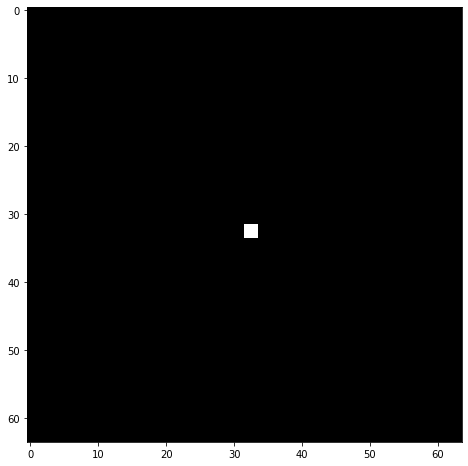

In [17]:
plt.imshow(observation)

In [18]:
# alright, now that I have my model, it's time to try doing some reinforcement learning

In [19]:
# start by doing a basic linear network from the observation space to the 

In [20]:
# replay buffer. Store (s, a, r, s_n, d) tuples
class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = []
        self.max_size = max_size
        self.insert_at = 0
    
    def add(self, s, a, r, s_n, d):
        if len(self.buffer) < self.max_size:
            self.buffer.append((s, a, r, s_n, d))
        else:
            self.buffer[self.insert_at] = (s, a, r, s_n, d)
            self.insert_at = (self.insert_at + 1) % self.max_size
    
    def sample_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def add_all(self, sarsd):
        for i in sarsd:
            buffer.add(*i)

In [233]:
def sample_training_batch(buffer, batch_size):
    batch = buffer.sample_batch(batch_size)
    s = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    a = np.zeros((batch_size, 1), dtype='int64')
    r = np.zeros((batch_size, 1), dtype='float32')
    s_n = np.zeros((batch_size, 64, 64, 3), dtype='float32')
    d = np.zeros((batch_size, 1), dtype='float32')

    
    for i, x in enumerate(batch):
        s[i] = x[0]
        a[i] = x[1]
        r[i] = x[2]
        s_n[i] = x[3]
        d[i] = x[4]
    
    s = torch.from_numpy(s).permute((0, 3, 1, 2)).cuda() / 255
    s_n = torch.from_numpy(s_n).permute((0, 3, 1, 2)).cuda() / 255
    a = torch.from_numpy(a).cuda()
    r = torch.from_numpy(r).cuda()
    d = torch.from_numpy(d).cuda()
    
    return s, a, r, s_n, d

In [234]:
buffer = ReplayBuffer()

In [23]:
class EnvSamplingWrapper:
    def __init__(self, env):
        self.env = env
        self.obs = env.reset()
        self.step_count = 0
        self.total_reward = 0
    
    def sample(self, count, policy):
        tuples = []
        rewards = []
        for i in range(count):
            self.step_count += 1
            action = policy(self.obs)
            observation, reward, done, info = env.step(action)
            tuples.append((self.obs, action, reward, observation, done))
            self.obs = observation
            self.total_reward += reward
            if done:
                self.obs = env.reset()
                rewards.append((self.total_reward, self.step_count))
                self.total_reward = 0
        
        return tuples, rewards

In [24]:
env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [25]:
sarsd, rew = env_wrapper.sample(500, lambda x: env.action_space.sample())

In [26]:
rew

[(4, 200), (17, 317)]

In [27]:
def prod(x):
    total = 1
    for i in x:
        total *= i
    return total

In [28]:
prod(env.observation_space.shape)

12288

In [29]:
env.action_space.n

4

In [30]:
class DQN_Net(nn.Module):
    def __init__(self, input_size, action_size):
        super().__init__()
#         print(input_size)
        self.net = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, action_size),
        )
        with torch.no_grad():
            self.net[-1].weight[:,:] = 0
    
    def forward(self, x):
#         print(x.shape)
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = self.net(x)
        return x

In [31]:
model = DQN_Net(prod(env.observation_space.shape), env.action_space.n)

In [32]:
model.cuda()

DQN_Net(
  (net): Sequential(
    (0): Linear(in_features=12288, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [33]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00025)

In [34]:
def dqn_policy(model, obs):
    # scale the obs, change to model shape
    image = torch.from_numpy(to_batch_shape(obs)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        action = torch.argmax(outputs).item()
    
    return action

In [35]:
dqn_policy(model, observation)

0

In [36]:
buffer = ReplayBuffer()

In [237]:
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())

for i in sarsd:
    buffer.add(*i)

In [499]:
def train_batch(model, target, buffer, optimizer):
    # get the inputs
    
    # sample from the buffer and preprocess next qs
    s, a, r, s_n, d = sample_training_batch(buffer, 32)
#     print(d)
    
    # get the next qs
    with torch.no_grad():
        outputs = target(s_n)
        q_n, a_n = torch.max(outputs, 1)
        # Avoid potential broadcast issue
        q_n = q_n.view(-1, 1)
#         print(q_n.shape)
        targets = r * (1.0) + q_n * (1 - d) * 0.99

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    
    # forward + backward + optimize
    outputs = model(s)
#     print(a.shape)
    
    # get the target action to diff the target with
    v = torch.gather(outputs, 1, a)
#     print(v.shape, outputs.shape)

    if torch.isnan(outputs).any():
        print("There's a NaN output!")
        return None
    loss = F.smooth_l1_loss(v, targets)

    loss.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
    optimizer.step()

    return loss.detach().item()

In [500]:
train_batch(model, target, buffer, optimizer)

0.48316335678100586

In [501]:
class DQN_Policy:
    def __init__(self, model, epsilon, sampler):
        self.model = model
        self.epsilon = epsilon
        self.sampler = sampler
    
    def __call__(self, obs):
        if random.random() < self.epsilon:
            return self.sampler()
        return dqn_policy(model, obs)

In [502]:
# from https://github.com/ghliu/pytorch-ddpg/blob/e9db328ca70ef9daf7ab3d4b44975076ceddf088/util.py#L26
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

In [503]:
def dqn_loop(model, target, env_wrapper, buffer, optimizer, steps, STATS):
    running_loss = None
    
    next_exploration = 0.95
    with tqdm(range(steps), unit="batch") as t:
        for i in t:
            
            if i % 1000 == 0:
                policy = DQN_Policy(model, next_exploration, env_wrapper.env.action_space.sample)
                next_exploration -= 0.05
                next_exploration = max(next_exploration, 0.05)
            
            sarsd, rew = env_wrapper.sample(1, policy)
            buffer.add_all(sarsd)
            STATS['returns'].extend(rew)
            
            if (i + 1) % 4 != 0:
                continue

            loss = train_batch(model, target, buffer, optimizer)
            STATS["loss"].append(loss)

            if i % 10000 == 0:
                soft_update(target, model, 1.0)
#             soft_update(target, model, 0.000001)
            if running_loss is None:
                running_loss = loss
            running_loss = running_loss * 0.999 + loss * 0.001
            if (i + 1) % 100 == 0:  # print every N mini-batches
                string = 'loss: %.8f' % (
                    running_loss
                )
                t.set_postfix_str(string)

In [504]:
model = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
model.cuda()

DQN_Net(
  (net): Sequential(
    (0): Linear(in_features=12288, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [505]:
target = DQN_Net(prod(env.observation_space.shape), env.action_space.n)
target.cuda()
target.eval()
soft_update(target, model, 1.0)

In [506]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
# optimizer = Lion(model.parameters(), lr=0.00001)

In [507]:
env = DotEnv()
env_wrapper = EnvSamplingWrapper(env)

In [508]:
buffer = ReplayBuffer()
# initialize the buffer:
sarsd, rew = env_wrapper.sample(10000, lambda x: env.action_space.sample())
buffer.add_all(sarsd)

In [509]:
STATS = defaultdict(list)

In [510]:
dqn_loop(model, target, env_wrapper, buffer, optimizer, 100000, STATS)

100%|██████████████████████████████████| 100000/100000 [01:36<00:00, 1036.17batch/s, loss: 0.00186391]


In [511]:
STATS['returns'][-10:]

[(27, 109605),
 (48, 109655),
 (32, 109695),
 (51, 109750),
 (35, 109791),
 (57, 109850),
 (41, 109891),
 (33, 109926),
 (34, 109966),
 (26, 109992)]

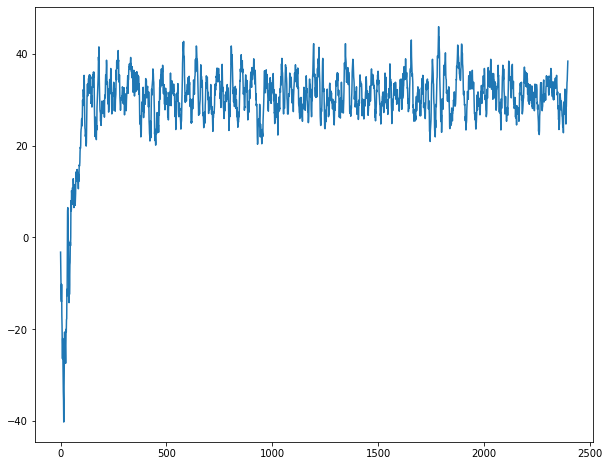

In [512]:
plt.plot(np.convolve(np.asarray([x[0] for x in STATS['returns']]), np.ones((10,)) / 10, mode='valid'))

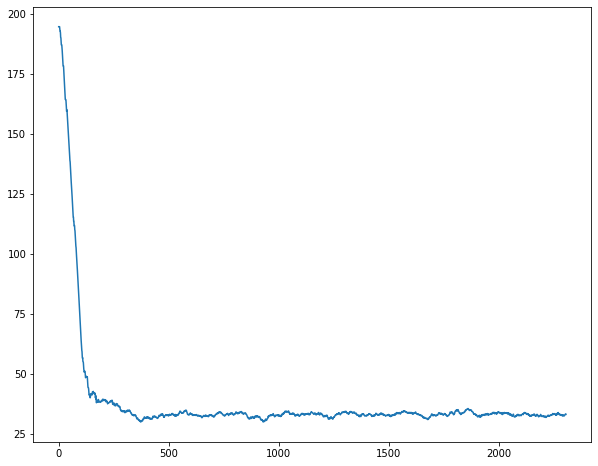

In [513]:
plt.plot(np.convolve(np.convolve(np.asarray([x[1] for x in STATS['returns']]), np.asarray([1, -1]), mode='valid'), np.ones((100,)) / 100, mode='valid'))

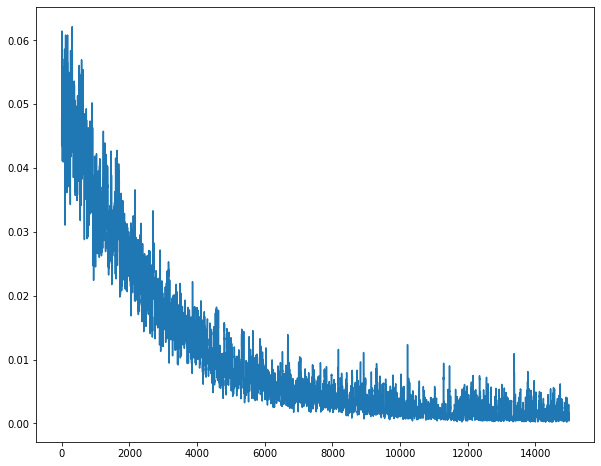

In [514]:
plt.plot(np.convolve(np.asarray(STATS['loss']), np.ones((10,)) / 10, mode='valid')[10000:])

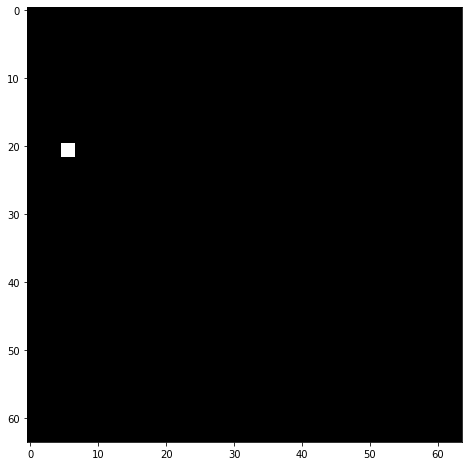

In [467]:
observation = buffer.buffer[12346][0]
plt.imshow(observation)

In [625]:
# scale the obs, change to model shape
image = torch.from_numpy(to_batch_shape(observation)).permute((0, 3, 1, 2)).cuda() / 255
with torch.no_grad():
    outputs = model(image)
    action = torch.argmax(outputs).item()

In [626]:
outputs

tensor([[0.2791, 0.2780, 0.2795, 0.2789]], device='cuda:0')

In [627]:
# action_to_vector = {
#     0: np.array([0, -1]),  # Up
#     1: np.array([1, 0]),   # Right
#     2: np.array([0, 1]),   # Down
#     3: np.array([-1, 0])   # Left
# }

In [106]:
# evaluate the model on all possible states, then tally up the error

# generate all possible states, and calculate their distance
states = []
for i in range(62):
    for j in range(62):
        observation = np.zeros((64, 64, 3), dtype=np.uint8)
        observation[i:i+2, j:j+2] = np.array([255, 255, 255])
        distance = abs(32 - i) + abs(32-j)
        states.append((observation, distance))

In [107]:
loss = 0

for s, distance in states:
    image = torch.from_numpy(to_batch_shape(s)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
#         print(outputs)
        q_n, a_n = torch.max(outputs, 1)
        q_n = q_n.item() * 100
    
    loss += abs(q_n - distance)
loss


118164.4397746427

In [108]:
short_states = [x for x in states if x[1] < 3]

In [109]:
len(short_states)

13

In [1]:
loss = 0

for s, distance in short_states:
    image = torch.from_numpy(to_batch_shape(s)).permute((0, 3, 1, 2)).cuda() / 255
    with torch.no_grad():
        outputs = model(image)
        print(outputs * 100, distance)
        q_n, a_n = torch.max(outputs, 1)
        q_n = q_n.item() * 100
    
    loss += abs(q_n - distance)
loss

NameError: name 'short_states' is not defined

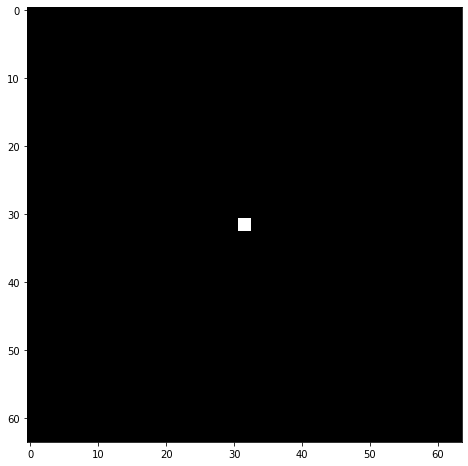

In [671]:
plt.imshow(short_states[1][0])